City Neighborhood Classifier 

CS 305: Machine Learning Fall 2021

Sara Clark, Christine Pourheydarian, Jiawei Liu


In [1]:
!pip3 install kaggle

In [5]:
import numpy as np
import pandas as pd
import csv
import random
random.seed(42)

In [6]:
'''
importing the calendar.csv data. 
listing id stays a number
date is kept in its form but has the dashes removed
available: if f, then becomes 0. if t, then becomes 1. 
price: converted from currency to a double. if there is no price, the value inserted is None. 
'''


from re import sub
from decimal import Decimal


calendar_csvfile = open('archive/calendar.csv', 'r')#listing_id,date,available,price
reader = csv.reader(calendar_csvfile, delimiter=',', quotechar='"')
calendar_data = []

for row in reader: 
    r  = [ ]
    for i in range(4):
        if i == 0:
            date = (row[1]).replace("-", "")
            r.append(date)
        elif i == 1:
            available = 0 if row[2] == "f" else 1 #f: 0, t: 1 
            r.append(available)
        elif i == 2:        
            money = row[3]
            if money == "":
                r.append(None)
                continue
            else: 
                value = float(Decimal(sub(r'[^\d.]', '', money)))#remove dollar sign, comma, and everything after the .
                r.append(value)
        elif i == 3: 
            listing_id  = int(row[0])
            r.append(listing_id)    
    calendar_data.append(r)


calendar_data_np = np.array(calendar_data)
print(calendar_data_np)

[['20170905' 0 None 12147973]
 ['20170904' 0 None 12147973]
 ['20170903' 0 None 12147973]
 ...
 ['20160908' 0 None 14504422]
 ['20160907' 0 None 14504422]
 ['20160906' 0 None 14504422]]


In [7]:
'''
Loading reviews.csv into numpy w/o any modification, i.e. w/o switching anything from qualitative to quantitative  
'''
from collections import defaultdict
csv_file = open('archive/reviews.csv', 'r')
reader = csv.reader(csv_file, delimiter=',', quotechar='"')
review_columns = []
data = []
reviews_and_ids = defaultdict(list) #key: listing id --> value: all comments corresponding to that listing id
for i, row in enumerate(reader):
    if i == 0:
        review_columns = row
        continue
    r = []
    for i in range(6):
        r.append(row[i])
    
    listing_id, review_text = row[0], row[-1]
    reviews_and_ids[listing_id].append(review_text)
    data.append(r)

csv_file.close()
reviews = np.array(data)
# print("reviews columns:\n", review_columns)
# print("reviews data:\n", reviews)

all_reviews = [ ] #list of reviews 
#each element of the corpus corresponds to all reviews of one listing concatenated together
for listing_id, reviews in reviews_and_ids.items():
    reviews_combined = "".join(reviews)
    reviews_combined = reviews_combined.replace("\n", "") #remove unnecessary characters
    all_reviews.append(reviews_combined)

In [8]:
# listings = np.loadtxt('archive/listings.csv', delimiter=',', skiprows = 1)
'''
but leaving out rows that dont have a value for host_neighborhood  and/or neighborhood 

'''
from re import sub
from decimal import Decimal


listings_csvfile = open('archive/listings.csv', 'r') 
reader = csv.reader(listings_csvfile, delimiter=',', quotechar='"')
listings_data = []
column = None 
property_types = {'': 0, 'Condominium': 1, 'Camper/RV': 2, 'House': 3, 'Townhouse': 4, 'Entire Floor': 5, 
              'Guesthouse': 6, 'Boat': 7, 'Dorm': 8, 'Villa': 9, 'Bed & Breakfast': 10, 'Other': 11, 'Apartment': 12, 
              'Loft': 13 }

room_types = {'Private room': 0, 'Shared room': 1, 'Entire home/apt': 2}
beds = {'Couch': 0, 'Airbed':1, 'Pull-out Sofa':2, 'Real Bed':3, 'Futon':4}
calendar_updated = {'never': 0, 'yesterday': 1, 'today': 2, '2 days ago': 3, '3 days ago': 4,
                    '4 days ago': 5, '5 days ago': 6, '6 days ago': 7, 'a week ago': 8, '1 week ago': 9,
                    '2 weeks ago': 10, '3 weeks ago': 11,'4 weeks ago': 12, '5 weeks ago': 13, '6 weeks ago': 14, 
                    '7 weeks ago': 15,'2 months ago': 16,'3 months ago': 17,'4 months ago': 18,'5 months ago': 19,
                    '7 months ago': 20,'6 months ago': 21, '8 months ago': 22,'9 months ago': 23,'10 months ago':24,
                    '11 months ago':25,'12 months ago':26, '13 months ago': 27, '14 months ago': 28, '15 months ago': 29, '16 months ago': 30, 
                    '17 months ago': 31, '18 months ago': 32, '20 months ago': 33, '22 months ago': 34, '30 months ago': 35, 
                    '23 months ago': 36, '25 months ago': 37 }
cancellation_policy = {'flexible': 0, 'moderate': 1, 'strict': 2, 'super_strict_30': 3}
indicesSet = set([0,19,32,33,48,49,53,54,55,56,59,65, \
                  67,68,71,72,73,74,76,79,80,81,82,83,84,85,93,94,50,86,89,91,92,51,52,57,\
                 60,61,62,63,64,66,69,90]) #columns included in the numpy array 
neighborhoods = [ ]
neighborhoodMatch = {} #a dictionary that maps a listing to a neighborhood tag in form "listing_id:neighborhood"
textFeatures = set()
listing_columns = [ ]
for index, row in enumerate(reader): 
    if index == 0:
        listing_columns = row
        continue
    #removing rows without a listed neighborhood in either of these 4 columns that correspond to neighborhood
    host_neighbourhood = row[31]
    neighbourhood = row[38]
    neighbourhood_cleansed = row[39]
    neighbourhood_group_cleansed = row[40]
    
    listing_id = row[0]

    if not neighbourhood and not host_neighbourhood \
        and not neighbourhood_cleansed and not neighbourhood_group_cleansed:
        continue 
    #adding neighborhood from whatever column it's stored in
    if neighbourhood: 
        neighborhoods.append(neighbourhood)
        neighborhoodMatch[listing_id]=neighbourhood
    elif neighbourhood_cleansed:
        neighborhoods.append(neighbourhood_cleansed)
        neighborhoodMatch[listing_id]=neighbourhood_cleansed
    elif neighbourhood_group_cleansed:
        neighborhoods.append(neighbourhood_group_cleansed)
        neighborhoodMatch[listing_id]=neighbourhood_group_cleansed
        
        

    if index == 0:
        columns = row
    r  = [ ] #row values
    for i in range(95): #i is a column index 
        if index == 0 and i in indicesSet: #then this is the header column names
            r.append(row[i])
        elif i == 0 or i == 19 or i == 32 or i == 33 \
            or i == 48 or i == 49 or i == 53 or i == 54 or i == 55 or i == 56 or i == 59 \
            or i == 65 or i == 67 or i == 68 or (i >=71 and i <= 74) or i == 76 or (i >= 79 \
            and i <= 85) or i ==  93 or i == 94: #listing id, host id 
            if row[i] == "N/A" or row[i] == "":
                r.append(None)
                continue 
            else:
                val = row[i] 
                r.append(val)
        elif i == 50 or i == 86 or i == 89 or i == 91 or i == 92:
            if row[i] == "N/A" or row[i] == "":
                r.append(2)
                continue 
            else:
                boolean = 0 if row[i] == "f" else 1 
                r.append(boolean)
        elif i == 51:
            if row[i] == "N/A" or row[i] == "":
                r.append(14)
                continue 
            else:
                property_type = property_types[row[i]]
                r.append(property_type)
        elif i == 52:
            if row[i] == "N/A" or row[i] == "":
                r.append(3)
                continue 
            else:
                room_type = room_types[row[i]] 
                r.append(room_type)
        elif i == 57:
            if row[i] == "N/A" or row[i] == "":
                r.append(4)
                continue 
            else:
                bed = row[i]
                r.append(beds[bed])
        elif (i >=  60 and i <= 64) or i == 66: 
            if row[i] == "N/A" or row[i] == "":
                r.append(0)
                continue 
            else:
                money = row[i]
                value = float(Decimal(sub(r'[^\d.]', '', money)))#remove dollar sign, comma, and everything after the .
                r.append(value)
        elif i == 69: #calendar_updated col 
            if row[i] == "N/A" or row[i] == "":
                r.append(38)
                continue 
            else:
                date = row[i]
                r.append(calendar_updated[date])  
        elif i == 90:
            if row[i] == "N/A" or row[i] == "":
                r.append(4)
                continue 
            else:
                policy = row[i]
                val = cancellation_policy[(policy)] 
                r.append(val)
        elif i == 4 or i == 5 or i == 6 or i == 7 or i== 9 or i == 10 or i== 11 or i == 12 or i== 13 or i== 14 or i == 24 or i == 51 or i == 52 or i == 58: 
            if row[i] == "N/A" or row[i] == "":
                r.append("N/A")
                textFeatures.add(len(r))
                continue 
            else: 
                text = row[i]
                textFeatures.add(len(r))
                r.append(text)
    #get all reviews associated with the listing and then add them in the last column as one giant string
    listing_id = str(row[0])
    if listing_id in reviews_and_ids:
        reviews = reviews_and_ids[listing_id]
        blob_of_reviews = "".join(reviews)
    else:
        blob_of_reviews = ""
    r.append(blob_of_reviews)
    textFeatures.add(len(r)-1)
    listings_data.append(r)

listings_numerical_data = np.array(listings_data)
neighborhoods = np.array(neighborhoods)
allLabels, labelsCounts = np.unique(neighborhoods, return_counts=True)
print(textFeatures)
print("listings data \n", listings_numerical_data[:1,:]) #first row
# print("listing_columns\n", listing_columns)
# print("listings data \n", listings_numerical_data[:5,:]) #first 5 rows
# print("neighborhoods data \n", neighborhoods)
# print("neighborhoods & listing matching \n", list(neighborhoodMatch.items())[:5])

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 56, 25}
listings data 
 [['12147973' 'Sunny Bungalow in the City'
  'Cozy, sunny, family home.  Master bedroom high ceilings. Deck, garden with hens, beehives & play structure.   Short walk to charming village with  attractive stores, groceries & local restaurants. Friendly neighborhood. Access public transportation.'
  'The house has an open and cozy feel at the same time.  The living room has a flat screen TV.  The kitchen has all you need for cooking.  We prefer you buy your food but can use the organic oils, herbs, etc.   The yard can be seen from sitting room and when the weather allows, the yard is a place children can lose themselves in a safe way.  We have 2 bee hives, 6 hens fenced in (sometimes they get out of their coop area & into the yard), 2 rabbits in a hutch and play structure.'
  "Cozy, sunny, family home.  Master bedroom high ceilings. Deck, garden with hens, beehives & play structure.   Short walk to charming village with  

total # neighborhoods 
 23
Allston-Brighton Count : 432
Back Bay Count : 330
Beacon Hill Count : 210
Brookline Count : 12
Cambridge/Somerville Count : 22
Charlestown Count : 98
Chinatown Count : 84
Dorchester Count : 260
Downtown Count : 83
East Boston Count : 149
Fenway/Kenmore Count : 293
Hyde Park Count : 32
Jamaica Plain Count : 343
Mattapan Count : 28
Mission Hill Count : 122
North End Count : 145
Roslindale Count : 56
Roxbury Count : 148
South Boston Count : 258
South End Count : 330
Theater District Count : 34
West End Count : 74
West Roxbury Count : 42


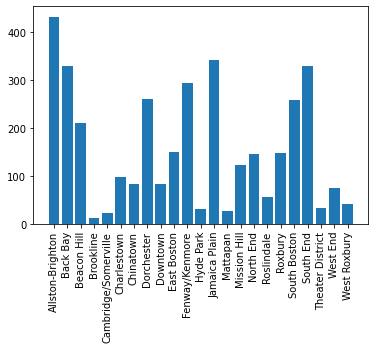

In [37]:
import matplotlib.pyplot as plt

#CONSOLIDATE BOSTON NEIGHBORHOODS
for count, neighborhood in enumerate(neighborhoods):
    if neighborhood in ['Cambridge','Harvard Square', 'Somerville']:
        neighborhoods[count] = "Cambridge/Somerville"
    elif neighborhood in ['Allston','Brighton']:
        neighborhoods[count] = "Allston-Brighton"
    elif neighborhood in ['Fenway', 'Longwood Medical Area']:
        neighborhoods[count] = "Fenway/Kenmore"
    elif neighborhood in ['Downtown Crossing','Government Center', 'Financial District', 'Leather District']:
        neighborhoods[count] = "Downtown"
    elif neighborhood == 'Bay Village':
        neighborhoods[count] = "Theater District"
    elif neighborhood == 'Chestnut Hill':
        neighborhoods[count] = "Brookline"
    elif neighborhood == 'South Boston Waterfront':
        neighborhoods[count] = "South Boston"
allLabels, labelsCounts = np.unique(neighborhoods, return_counts=True)
print("total # neighborhoods \n", len(allLabels) )
indices = np.arange(1,labelsCounts.shape[0]+1)
plt.xticks(rotation=90)
plt.bar(indices, labelsCounts, width=0.8, tick_label=allLabels)
for i in range(labelsCounts.shape[0]):
    print(allLabels[i], "Count :", labelsCounts[i])


Christine's to-dos:
-  remove stuff internally used
- leave dates in date form 
- join on the reviews

Split Data By Neighborhood and Recombine (SARA)

In [38]:
from functools import reduce 
#1. Divide data by neighborhood
dividedData = [None] * len(allLabels)
for count, label in enumerate(allLabels):
    filter_arr = []
    for i, neighborhood in enumerate(neighborhoods):
        if neighborhood == label:
            filter_arr.append(listings_numerical_data[i])
    dividedData[count] = np.array(filter_arr)
#Randomly permute each row of a given neighborhood
    random.shuffle(dividedData[count])


In [39]:
    
# Split into Training and Testing
trainPercentage = 0.60
validationPercentage= 0.15
testPercentage= 0.25
trainX = []
testX = []
validationX = []
trainY = []
validationY = []
testY = []

#Split and recombine neighborhoods
for i in range(len(dividedData)):
    trainSize = int(len(dividedData[i])*trainPercentage)
    validationSize = int(len(dividedData[i])*validationPercentage)
    testSize = len(dividedData[i])- trainSize - validationSize
    print(allLabels[i],trainSize,validationSize, testSize)
    trainX.append(dividedData[i][:trainSize])
    trainY = trainY + ([allLabels[i]]*trainSize)
    
    validationX.append(dividedData[i][trainSize:trainSize+validationSize])
    validationY = validationY + ([allLabels[i]]*validationSize)
    
    testX.append(dividedData[i][trainSize+validationSize:])
    testY = testY + ([allLabels[i]]*testSize)
    
#Reformat Arrays
trainX = np.array(trainX, dtype='object')
trainX = np.concatenate(trainX)
validationX = np.array(validationX, dtype='object')
validationX = np.concatenate(validationX)
testX = np.array(testX, dtype='object')
testX = np.concatenate(testX)
trainY = np.array(trainY)
validationY = np.array(validationY)
testY = np.array(testY)

Allston-Brighton 259 64 109
Back Bay 198 49 83
Beacon Hill 126 31 53
Brookline 7 1 4
Cambridge/Somerville 13 3 6
Charlestown 58 14 26
Chinatown 50 12 22
Dorchester 156 39 65
Downtown 49 12 22
East Boston 89 22 38
Fenway/Kenmore 175 43 75
Hyde Park 19 4 9
Jamaica Plain 205 51 87
Mattapan 16 4 8
Mission Hill 73 18 31
North End 87 21 37
Roslindale 33 8 15
Roxbury 88 22 38
South Boston 154 38 66
South End 198 49 83
Theater District 20 5 9
West End 44 11 19
West Roxbury 25 6 11


Text Analysis
- Remove neighborhood names from text-based feature columns used for training
- Bag of words: tfid vectorization
- Link reviews to correct neighborhood



In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorizeText(i):
    #Vectorize an individual column
    corpus_train = trainX[:, i]
    corpus_validate = validationX[:,i]
    vectorizer = TfidfVectorizer(min_df=5, max_features=1000)  # Use individual words as tokens
    textX_train = vectorizer.fit_transform(corpus_train).toarray()
    textX_validate = vectorizer.transform(corpus_validate).toarray()
    print(i)
    print(vectorizer.get_feature_names())
    print(vectorizer.idf_)
    return np.array(textX_train), np.array(textX_validate)
    
for i in sorted(textFeatures): # for each text based column that requires vectorization
    corpus_train = []
    corpus_validate = []
    trainVectorized, validateVectorized = vectorizeText(i)
    for j in range(trainX.shape[0]): #replace text value with vectorized text in training data
        trainX[j, i] = trainVectorized[i]
    for j in range(validationX.shape[0]): #replace text value with vectorized text in validation data
        validationX[j, i] = validateVectorized[i]
# print(trainX[0,:]) 
# print(trainX[0,:])
final_trainX = [None] * trainX.shape[0]
for i in range(trainX.shape[0]):
    final_trainX[i]=np.concatenate(trainX[i,:], axis=None)
final_trainX = np.array(final_trainX, dtype='float64')
final_validationX = [None] * validationX.shape[0]
for i in range(validationX.shape[0]):
    final_validationX[i]=np.concatenate(validationX[i,:], axis=None)
# print(final_trainX[1])
final_validationX = np.array(final_validationX, dtype='float64')
# print(final_trainX[0,:])
print(final_trainX.shape)
print(final_validationX.shape)
# print(np.concatenate(trainX, axis=None).shape)

1
['1246', '1250', '1279', '1293', '1294', '1480', '15', '1535', '1716', '1857', '1b', '1ba', '1bd', '1br', '1c', '2ba', '2bd', '2br', '2bth', '2c', '2nd', '38m', '3b', '3br', 'a1', 'access', 'across', 'airbed', 'airbnb', 'airport', 'all', 'allston', 'amazing', 'and', 'apart', 'apartment', 'apartments', 'apt', 'arboretum', 'area', 'artist', 'at', 'ave', 'avenue', 'away', 'ba', 'back', 'backbay', 'balcony', 'bath', 'bathroom', 'bay', 'baytownhouse', 'bc', 'bd', 'bdrm', 'be', 'beach', 'beacon', 'beautiful', 'beauty', 'bed', 'bedroom', 'bedrooms', 'beds', 'best', 'beyond', 'bi', 'big', 'bldg', 'boston', 'br', 'brand', 'bright', 'brighton', 'brookline', 'brownstone', 'btwn', 'bu', 'building', 'bunker', 'bus', 'business', 'by', 'center', 'central', 'charles', 'charlestown', 'charm', 'charming', 'chic', 'china', 'chinatown', 'circle', 'city', 'classic', 'classy', 'clean', 'close', 'colleges', 'colorful', 'columbus', 'comfort', 'comfortable', 'comfy', 'comm', 'common', 'commonwealth', 'condo'

3
['00', '10', '12', '14', '15', '150', '1860', '18th', '19th', '20', '24', '25', '2nd', '30', '39', '3rd', '40', '42', '50', 'about', 'ac', 'access', 'accessible', 'accommodate', 'accommodates', 'across', 'addition', 'additional', 'adjacent', 'aerobed', 'after', 'air', 'airbnb', 'airport', 'alcove', 'all', 'along', 'also', 'always', 'am', 'amazing', 'amenities', 'amenity', 'ample', 'an', 'and', 'another', 'any', 'anything', 'anywhere', 'apartment', 'apartments', 'apple', 'applianced', 'appliances', 'appointed', 'apt', 'aquarium', 'arboretum', 'architectural', 'architecture', 'are', 'area', 'areas', 'arlington', 'around', 'arrival', 'art', 'arts', 'as', 'ask', 'at', 'attached', 'attractions', 'available', 'avenue', 'away', 'back', 'backdrop', 'backyard', 'balconies', 'balcony', 'bar', 'bars', 'base', 'basement', 'basic', 'basics', 'basketball', 'bath', 'bathroom', 'bathrooms', 'baths', 'bathtub', 'bay', 'be', 'beacon', 'beautiful', 'beautifully', 'beauty', 'because', 'bed', 'bedroom', 

4
['10', '100', '12', '15', '1860', '19th', '20', '24', '25', '2nd', '30', '39', '3rd', '40', '42', '50', '500', 'able', 'about', 'above', 'ac', 'access', 'accessible', 'accommodate', 'accommodates', 'across', 'addition', 'additional', 'adjacent', 'adventurers', 'after', 'air', 'airbnb', 'airport', 'all', 'along', 'also', 'always', 'am', 'amazing', 'ambiance', 'amenities', 'amenity', 'ample', 'an', 'and', 'another', 'answer', 'antique', 'any', 'anything', 'anywhere', 'apartment', 'apartments', 'applianced', 'appliances', 'appointed', 'apt', 'aquarium', 'arboretum', 'architecture', 'are', 'area', 'areas', 'arlington', 'arnold', 'around', 'arrival', 'arrive', 'art', 'arts', 'as', 'ashmont', 'ask', 'at', 'attractions', 'available', 'ave', 'avenue', 'away', 'awesome', 'back', 'backyard', 'bakery', 'balconies', 'balcony', 'bar', 'bars', 'base', 'basement', 'basic', 'basketball', 'bath', 'bathroom', 'bathrooms', 'baths', 'bay', 'bc', 'be', 'beach', 'beacon', 'beautiful', 'beautifully', 'beca

6
['00', '00am', '10', '100', '11', '110', '12', '15', '1pm', '20', '24', '25', '26', '2nd', '30', '3pm', '3rd', '4th', '50', '5pm', '6pm', '72', '85', '8am', '9pm', 'able', 'about', 'above', 'absolutely', 'ac', 'access', 'accessed', 'accessories', 'accommodate', 'accoutrements', 'across', 'activated', 'address', 'advance', 'affordable', 'after', 'ahead', 'air', 'airbnb', 'airport', 'all', 'allergic', 'allergies', 'allow', 'allowed', 'allows', 'along', 'already', 'also', 'although', 'always', 'am', 'amenities', 'amount', 'ample', 'an', 'and', 'angled', 'animals', 'another', 'any', 'anyone', 'anything', 'anytime', 'anyway', 'apartment', 'apartments', 'apple', 'appliances', 'appreciate', 'apt', 'are', 'area', 'areas', 'around', 'arrangements', 'arrival', 'arrive', 'arriving', 'art', 'as', 'ashur', 'ask', 'at', 'august', 'available', 'ave', 'avenue', 'aware', 'away', 'back', 'bad', 'bag', 'bags', 'bars', 'basement', 'basic', 'basis', 'bath', 'bathroom', 'bathrooms', 'bay', 'be', 'beacon',

7
['000', '10', '100', '12', '120', '14', '15', '151', '16', '17', '18', '18th', '197', '19th', '20', '2016', '217', '21st', '24', '25', '28', '30', '300', '35', '36', '37', '38', '39', '40', '41', '43', '45', '50', '500', '501', '505', '51', '57', '5min', '5th', '60', '64', '66', '70', '70a', '72', '720', '82', '840', '86', '8am', '8pm', '90', '92', '93', 'able', 'about', 'above', 'access', 'accessed', 'accessible', 'accoun', 'across', 'addition', 'additional', 'adjacent', 'afield', 'after', 'airport', 'airports', 'all', 'allow', 'allston', 'alma', 'almost', 'along', 'also', 'alternative', 'although', 'always', 'am', 'amenities', 'america', 'ample', 'amtrak', 'an', 'and', 'andrew', 'another', 'any', 'anyone', 'anyplace', 'anything', 'anywhere', 'apartment', 'apartments', 'app', 'appliances', 'approx', 'april', 'aquarium', 'arch', 'are', 'area', 'areas', 'arlington', 'around', 'arrange', 'arrival', 'arrive', 'art', 'arts', 'as', 'ashmont', 'ask', 'at', 'attending', 'attention', 'attrac

9
['24', '24hr', '30', 'able', 'about', 'above', 'access', 'accessible', 'accommodations', 'address', 'advance', 'advice', 'advise', 'after', 'agents', 'ahead', 'airbnb', 'airport', 'all', 'allow', 'almost', 'alone', 'along', 'also', 'always', 'am', 'an', 'and', 'andrew', 'another', 'answer', 'any', 'anything', 'anytime', 'apartment', 'apartments', 'apt', 'are', 'area', 'arise', 'around', 'arrival', 'arrivals', 'arrive', 'arriving', 'as', 'ask', 'assist', 'assistance', 'at', 'attractions', 'automated', 'available', 'aware', 'away', 'back', 'bars', 'bathroom', 'be', 'because', 'bedroom', 'been', 'beer', 'before', 'being', 'best', 'between', 'big', 'bike', 'bit', 'booking', 'boston', 'both', 'box', 'boyfriend', 'breakfast', 'building', 'busy', 'but', 'by', 'call', 'called', 'calls', 'can', 'case', 'cell', 'chance', 'chat', 'check', 'checking', 'chose', 'city', 'cleaning', 'close', 'code', 'coffee', 'come', 'comfortable', 'coming', 'committed', 'communicate', 'communication', 'company', '

10
['00', '00pm', '02114', '10', '100', '10am', '10pm', '11', '11am', '11pm', '12', '1pm', '20', '24', '25', '29', '300', '30pm', '350', '3pm', '40', '4pm', '50', '62', '6pm', '7am', '8a', '8am', '8pm', '9am', '9p', '9pm', 'abide', 'able', 'about', 'above', 'absolutely', 'ac', 'accept', 'accepted', 'access', 'accessible', 'accidents', 'accommodate', 'accommodations', 'accompanied', 'account', 'act', 'action', 'ad', 'additional', 'address', 'adults', 'advance', 'affordable', 'after', 'age', 'agree', 'agreed', 'agreement', 'ahead', 'air', 'airbnb', 'alcohol', 'all', 'allow', 'allowed', 'also', 'although', 'always', 'am', 'amount', 'an', 'and', 'animals', 'another', 'any', 'anyone', 'anything', 'anytime', 'anywhere', 'apartment', 'apartments', 'apologies', 'appliances', 'apply', 'appreciate', 'appropriate', 'approval', 'apt', 'are', 'area', 'areas', 'aren', 'arising', 'around', 'arrange', 'arrival', 'arrivals', 'arrive', 'arrived', 'arriving', 'as', 'ask', 'asked', 'asks', 'assuming', 'at

12
['00', '10', '12', '14', '15', '18', '1840', '20', '200', '2014', '2015', '24', '30', '31', '3pm', '9am', 'ability', 'able', 'about', 'above', 'abroad', 'access', 'accommodate', 'accommodations', 'across', 'active', 'activities', 'addition', 'adventures', 'advice', 'africa', 'after', 'agency', 'agent', 'ago', 'ahead', 'ahold', 'airbnb', 'alan', 'alcohol', 'all', 'allen', 'almost', 'along', 'also', 'although', 'always', 'am', 'amazing', 'amenities', 'america', 'american', 'amount', 'an', 'and', 'angeles', 'any', 'anything', 'apartment', 'apartments', 'architect', 'architecture', 'are', 'area', 'areas', 'around', 'arrival', 'arrive', 'art', 'artist', 'arts', 'as', 'asia', 'ask', 'assist', 'assistance', 'association', 'assortment', 'assured', 'at', 'attention', 'attentive', 'attractions', 'availability', 'available', 'avid', 'award', 'away', 'awesome', 'babson', 'baby', 'back', 'barcelona', 'based', 'bath', 'bathrooms', 'bay', 'be', 'beach', 'beaches', 'beacon', 'beantown', 'beaten', '

56
['10', '100', '15', '20', '30', 'able', 'about', 'above', 'absolutely', 'ac', 'access', 'accessible', 'accommodate', 'accommodated', 'accommodating', 'accommodation', 'accommodations', 'accurate', 'across', 'actually', 'adorable', 'advertised', 'advice', 'affordable', 'after', 'again', 'air', 'airbnb', 'airport', 'alan', 'all', 'allowed', 'almost', 'along', 'already', 'also', 'although', 'always', 'am', 'amazing', 'amenities', 'an', 'and', 'andrea', 'another', 'answer', 'answered', 'any', 'anyone', 'anything', 'anywhere', 'apartment', 'appartement', 'appartment', 'appliances', 'appointed', 'appreciated', 'apt', 'are', 'area', 'areas', 'around', 'arrival', 'arrive', 'arrived', 'arriving', 'art', 'as', 'ask', 'asked', 'at', 'atef', 'attentive', 'attractions', 'au', 'automated', 'available', 'avec', 'avons', 'away', 'awesome', 'back', 'bad', 'bags', 'bars', 'base', 'basement', 'basic', 'bath', 'bathroom', 'bathrooms', 'bay', 'be', 'beacon', 'beat', 'beautiful', 'beautifully', 'because'

(2142, 11013)
(527, 11013)


In [42]:
# check for NaN
# array_sum = np.sum(final_trainX)
# array_has_nan = np.isnan(array_sum)
# print(array_has_nan)
final_trainX = np.where(final_trainX == None, final_trainX, -1)
array_sum = np.sum(final_trainX)
array_has_nan = np.isnan(array_sum)
print(array_has_nan)
final_validationX = np.where(final_validationX == None, final_validationX, -1)
array_sum = np.sum(final_validationX)
array_has_nan = np.isnan(array_sum)
print(array_has_nan)

False
False


In [43]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(final_trainX)
final_trainX = scaler.transform(final_trainX)
final_validationX = scaler.transform(final_validationX)

In [51]:
%%time
# Use different classifiers to predict neighborhood label
from sklearn.metrics import f1_score
from sklearn import linear_model  # Using sklearn Perceptron classifier
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble  # Using RandomForest classifier
from sklearn import neighbors  # Using nearest neighbors classifier

learners = {
    'Logistic Regression': LogisticRegression(multi_class='multinomial', class_weight="balanced"),
            'Perceptron': linear_model.Perceptron(max_iter=10, class_weight="balanced"),
            'RandomForest': ensemble.RandomForestClassifier(class_weight="balanced"),
#             'RandomForest': ensemble.RandomForestClassifier(class_weight="balanced"),
            'kNN': neighbors.KNeighborsClassifier()
            
           }
for classifierName in learners:
    print(classifierName)
    learners[classifierName].fit(final_trainX, trainY)
    predicted = learners[classifierName].predict(final_validationX)
    print('Score Accuracy of ' + classifierName + ':\t' + str(learners[classifierName].score(final_validationX, validationY)))
    print('F1 Accuracy of ' + classifierName + ':\t' + str(f1_score(validationY, predicted, average=None)))
    

Logistic Regression
Score Accuracy of Logistic Regression:	0.12144212523719165
F1 Accuracy of Logistic Regression:	[0.21658206 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
Perceptron


/Users/saraclark/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


Score Accuracy of Perceptron:	0.011385199240986717
F1 Accuracy of Perceptron:	[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.02251407]
RandomForest
Score Accuracy of RandomForest:	0.0018975332068311196
F1 Accuracy of RandomForest:	[0.         0.         0.         0.00378788 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
kNN
Score Accuracy of kNN:	0.03415559772296015
F1 Accuracy of kNN:	[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.06605505 0.         0.         0.
 0.         0.         0.         0.         0.        ]
CPU times: user 35.6 s, sys: 1.24 s, total: 36.9 s
Wall t

In [49]:
#Here is where Jiawei and Sara will do text analysis
# get an idea of test/train data looks like

# print("testX",testX[0:2,-1])
# print("trainX",trainX[0:2,-1])
# print("testY",testY[0:2])
# print("trainY",trainY[0:2])


# remove numbers from text reviews
from string import digits

def stripnumbers(string):
    return string.translate({ord(k): None for k in digits})


# make corpus and labels for tfidf vectorization

labels_train = trainY
labels_test = testY

corpus_train = []
corpus_test = []
for string in trainX[:,-1]:
    corpus_train.append(stripnumbers(string))
for string in testX[:,-1]:
    corpus_test.append(stripnumbers(string))


AttributeError: 'numpy.ndarray' object has no attribute 'translate'

In [50]:
# Text feature extraction for training data
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()  # Use individual words as tokens 
textX_train = vectorizer.fit_transform(corpus_train).toarray()
texty_train = np.array(labels_train)
print(textX_train.shape)
print(texty_train.shape)

ValueError: empty vocabulary; perhaps the documents only contain stop words

In [10]:
#features and their weights
print(vectorizer.get_feature_names())
print(vectorizer.idf_)


['_stellar_', 'aa', 'aailable', 'aan', 'aangenaam', 'aankomst', 'aankwamen', 'aanrader', 'aanwezig', 'aardig', 'aardige', 'aaron', 'aaronpete', 'ab', 'aback', 'abajo', 'abandon', 'abandonada', 'abandoned', 'abandonnée', 'abans', 'abastecerse', 'abastecimiento', 'abaño', 'abbas', 'abbastanz', 'abbastanza', 'abbiamo', 'abbildung', 'abbott', 'abby', 'abd', 'abe', 'abeilles', 'abend', 'abende', 'abends', 'aber', 'aberration', 'abfahrt', 'abfalltüten', 'abfliegt', 'abflug', 'abgebildet', 'abgelegen', 'abgenutzt', 'abgeschlossen', 'abgestellt', 'abgetrenntes', 'abgewohnt', 'abhishek', 'abide', 'abierta', 'abiertas', 'ability', 'abimer', 'abit', 'abita', 'abitata', 'abiti', 'ablageflächen', 'able', 'abnb', 'abnormal', 'aboard', 'abode', 'aboit', 'abord', 'abordable', 'aboretum', 'abound', 'abounds', 'about', 'above', 'aboyant', 'abraço', 'abreise', 'abreisetag', 'abren', 'abril', 'abrir', 'abrirles', 'abrirlo', 'abrió', 'abroad', 'abroadthis', 'abruptly', 'absehen', 'absence', 'absent', 'abse

In [11]:
# Text feature extraction for testing data
textX_test = vectorizer.transform(corpus_test).toarray()
texty_test = np.array(labels_test)
print(textX_test.shape)
print(texty_test.shape)

(916, 27558)
(916,)


In [12]:
%%time
# Use different classifiers to predict neighborhood label
from sklearn import linear_model  # Using sklearn Perceptron classifier
from sklearn import ensemble  # Using RandomForest classifier
from sklearn import neighbors  # Using nearest neighbors classifier

#Five Fold Cross Validation!!
learners = {'Perceptron': linear_model.Perceptron(max_iter=10),
            'RandomForest': ensemble.RandomForestClassifier(),
            'kNN': neighbors.KNeighborsClassifier()
           }
for classifierName in learners:
    learners[classifierName].fit(textX_train, texty_train)
    print('Accuracy of ' + classifierName + ':\t' + str(learners[classifierName].score(textX_test, texty_test)))

/Users/jwl/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


Accuracy of Perceptron:	0.5032751091703057
Accuracy of RandomForest:	0.5283842794759825
Accuracy of kNN:	0.2259825327510917
CPU times: user 49.3 s, sys: 618 ms, total: 49.9 s
Wall time: 33.8 s


In [13]:
# Get Perceptron weights
learner = linear_model.Perceptron(max_iter=10)
learner.fit(textX_train, texty_train)
weights = learner.coef_  # Get the learned Perceptron weights
# sorted_weights = np.argsort(weights)  # Sort
features = vectorizer.get_feature_names()  # Get the features
print(len(features))
print(weights.shape)

# print('\nClassName : weight pair: ')
# for n in range(weights.shape[0]): 
#     print("\nNeighborhood: "+str(y_train[n]))
#     for i in range(25): 
#         print("\nClassName: "+str(features[i])+" Weights: "+str(weights[n,i]))


# print('\nLowest weighted words (indicative of negative sentiment tweets)')
# for i in range(25): print(features[sorted_weights[0,i]])
# print('\nHighest weighted words (indicative of positive sentiment tweets)')
# for i in range(25): print(features[sorted_weights[0,len(sorted_weights[0])-i-1]])

27558
(23, 27558)


/Users/jwl/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


Feature Scaling

In [ ]:
#split data. rows already randomly permuted

# Split data into training (80%) and testing (20%).
# Use feature scaling to standardize the features.
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
X = listings_numerical_data
y = neighborhoods

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

def scaleData(trainX, testX):
    scaler = StandardScaler()
    scaler.fit(trainX)
    return scaler.transform(trainX), scaler.transform(testX)

X_train, X_test = scaleData(X_train, X_test)

split into training and testing
- first organize stuff by neighborhood
- randomly permute rows of each neighborhood set
- then select 25% of each neighborhood for testing and the rest for training
- combine the testing components and the training components

- **** we also planned to do cross validation, but maybe we can revisit that later?


In [ ]:
# Split data into training (80%) and testing (20%) and randomly permute rows
# Use feature scaling to standardize the features.
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
def scaleData(trainX, testX):
    scaler = StandardScaler()
    scaler.fit(trainX)
    return scaler.transform(trainX), scaler.transform(testX)

X_train, X_test = scaleData(X_train, X_test)

In [ ]:
# Cross validation

Create Classification models
- kNN
- random forest
- SVM
- Logistic Regression
- Neural Network (or Perceptron)




In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model  # Using sklearn Perceptron classifier
from sklearn import ensemble  # Using RandomForest classifier
from sklearn.svm import SVC

from sklearn import neighbors  # Using nearest neighbors classifier
# learners = {'Perceptron': linear_model.Perceptron(max_iter=10),
#             'RandomForest': ensemble.RandomForestClassifier(),
#             'kNN': neighbors.KNeighborsClassifier(),
#             'SVM': SVC(),
#             'LogisticRegression': linear_model.LogisticRegression(random_state=42)
#            },
           }
# for classifierName in learners:
#     learners[classifierName].fit(X_train, y_train)
#     print('Accuracy of ' + classifierName + ':\t' + str(learners[classifierName].score(X_test, y_test)))

In [ ]:
#Here is where Jiawei will do NN
# Get Perceptron weights
# learner = linear_model.Perceptron(max_iter=1)
learner.fit(X_train, y_train)
weights = learner.coef_  # Get the learned Perceptron weights
sorted_weights = np.argsort(weights)  # Sort
features = vectorizer.get_feature_names()  # Get the features
print('\nLowest weighted words (indicative of ham)')
for i in range(5): print(features[sorted_weights[0,i]])
print('\nHighest weighted words (indicative of spam)')
for i in range(5): print(features[sorted_weights[0,len(sorted_weights[0])-i-1]])

<h1>Testing<h1>

<h3>F1 Score</h3>

In [ ]:
# Train a sklearn Logistic Regression classifier on the scaled training data
# and report the F1 score of the classifier on the scaled testing data.

#from exercise 5 
from sklearn.linear_model import *
from sklearn.metrics import *


model = sklearn.linear_model.LogisticRegression().fit(X_train, y_train)
preds = model.predict(X_test)

sklearn.metrics.f1_score(y_test, preds)

<h3>Recall Score</h3>

In [ ]:
# Above you used default parameter settings for the SVM. 
# As in the previous task, let's explore different possible 
# values for the two parameters, C and gamma. For the C parameter, 
# experiment with the following six values: 0.01, 0.1, 1.0, 10.0, 100.0, and 1000.0. 
# For the gamma parameter, experiment with the following six values: 
# 0.001, 0.01, 0.1, 1.0, 10.0, 100.0. Try all 36 combinations of these two parameters.

# Evaluate the accuracy of the SVM when different values are used for parameters C and gamma.
# For parameter C, explore values of 0.01, 0.1, 1.0, 10.0, 100.0, and 1000.0
# For parameter gamma, explore values of 0.001, 0.01, 0.1, 1.0, 10.0, and 100.0 
#from exercise 7 
C = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
gamma = 0.001, 0.01, 0.1, 1.0, 10.0, 100.0
max_accuracy = 0 
max_c = 0 
max_gamma = 0 
for c in C: 
    for g in gamma: 
        clf = make_pipeline(StandardScaler(), SVC(C=c, gamma=g))
        clf.fit(X_train_pca, y_train)
        score = clf.score(X_test_pca, y_test)
        if score > max_accuracy: 
            max_accuracy = score
            max_c = c
            max_gamma = g

print('c', max_c)
print('gamma', max_gamma)

print('testing', max_accuracy)

clf = make_pipeline(StandardScaler(), SVC(C=max_c, gamma=max_gamma))
clf.fit(X_train_pca, y_train)
score = clf.score(X_train_pca, y_train)
print('training', score)

In [ ]:
# Using optimal values for parameters C and gamma,
# assess the precision, recall, and F1 score of the SVM on each class (person)

#from exercise 7 
from sklearn.metrics import classification_report
import sklearn.svm as svm
clf = svm.SVC(C = 10, gamma = .001)
clf = clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)
print(classification_report(y_test, y_pred, target_names=people))